In [1]:
import vit
from dataset import Yoga82
from dataset_utils import calculate_mean_std, get_train, get_test
from train import train
from eval import model_analysis
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader

In [8]:
# Settings
config = {
    "num_classes": 82,
    "img_size": 144,
    "img_channels": 3,
    "patch_size": 12,
    "hidden_size": 2048,
    "num_hidden_layers": 12,
    "num_attention_heads": 12,
    "mlp_hidden_size": 2048,
    "initializer_range": 0.02,
    "learning_rate": 1e-7,
    "betas": (0.9, 0.999),
    "weight_decay": 0.3,
    "batch_size": 32,
    "device": 'cuda',
    "epochs": 100,
    "hierarchy_level": 1,
    "load_pretrained": False,
    "transfer_learning": False,
}

In [3]:
X_train, y_train_6, y_train_20, y_train_82 = get_train()
X_test, y_test_6, y_test_20, y_test_82 = get_test()

if config["hierarchy_level"] == 1:
    y_train = y_train_6
    y_test = y_test_6
    config["num_classes"] = 6
elif config["hierarchy_level"] == 2:
    y_train = y_train_20
    y_test = y_test_20
    config["num_classes"] = 20
elif config["hierarchy_level"] == 3:
    y_train = y_train_82
    y_test = y_test_82
    config["num_classes"] = 82

Train Dataset Total: 14976
Test Dataset Total: 5131


In [4]:
# Prepare Dataset

# Calculate mean and std from X_train for Normalization,
# Takes a while, so save it after you do it so it's faster next time :3

# mean, std = calculate_mean_std(X_train)
mean = [0.6732, 0.6525, 0.6263]
std = [0.2339, 0.2360, 0.2378]


print("Mean:", mean)
print("Std:", std)

# Tranformations for Data Augmentation and Normalize

transform = transforms.Compose([
    #transforms.Resize((config['img_size'], config['img_size'])),
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor(), #It's already loaded as a tensor, so it's not necesary
    transforms.Normalize(mean=mean, std=std),
])

# Takes between 5 and 6 minutes for me uwu
train_dataset = Yoga82(X_train, y_train, transform=transform, resize=config["img_size"], num_channels=config["img_channels"])
test_dataset = Yoga82(X_test, y_test, transform=transform, resize=config["img_size"], num_channels=config["img_channels"])

Mean: [0.6732, 0.6525, 0.6263]
Std: [0.2339, 0.236, 0.2378]


c:\Users\felip\anaconda3\envs\vit\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
# Create a Sampler to Balance Dataset
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data.sampler import WeightedRandomSampler

class_weights = compute_class_weight('balanced', classes=range(max(y_train)+1), y=y_train)
class_weights = 1.0  /torch.tensor(class_weights, dtype=torch.float32)
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

#Create model and training parameters
device = config["device"]
batch_size = config["batch_size"]
lr = config["learning_rate"]
betas = config["betas"]
weight_decay = config["weight_decay"]
model = vit.ViT(config).to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
if config["load_pretrained"]:
    checkpoint = torch.load('model_82_classes.pth')

    #Remove Clasification MLP W and B for Transfer Learning
    if config["transfer_learning"]:
        checkpoint['model_state_dict'].pop('cls_layer.weight', None)
        checkpoint['model_state_dict'].pop('cls_layer.bias', None)

    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

In [11]:
train(model, train_dataloader, optimizer, criterion, config)

Train Loss per Step,█▁
Train Loss per Step,22.62761


  0%|          | 0/468 [00:00<?, ?it/s]

In [ ]:
#checkpoint = torch.load('model_checkpoint_epoch_5.pth')

#model.load_state_dict(checkpoint['model_state_dict'], strict=False)

<All keys matched successfully>

100%|██████████| 468/468 [05:52<00:00,  1.33it/s]


 Accuracy for Validation Dataset: 0.3816773504273504


0.3816773504273504

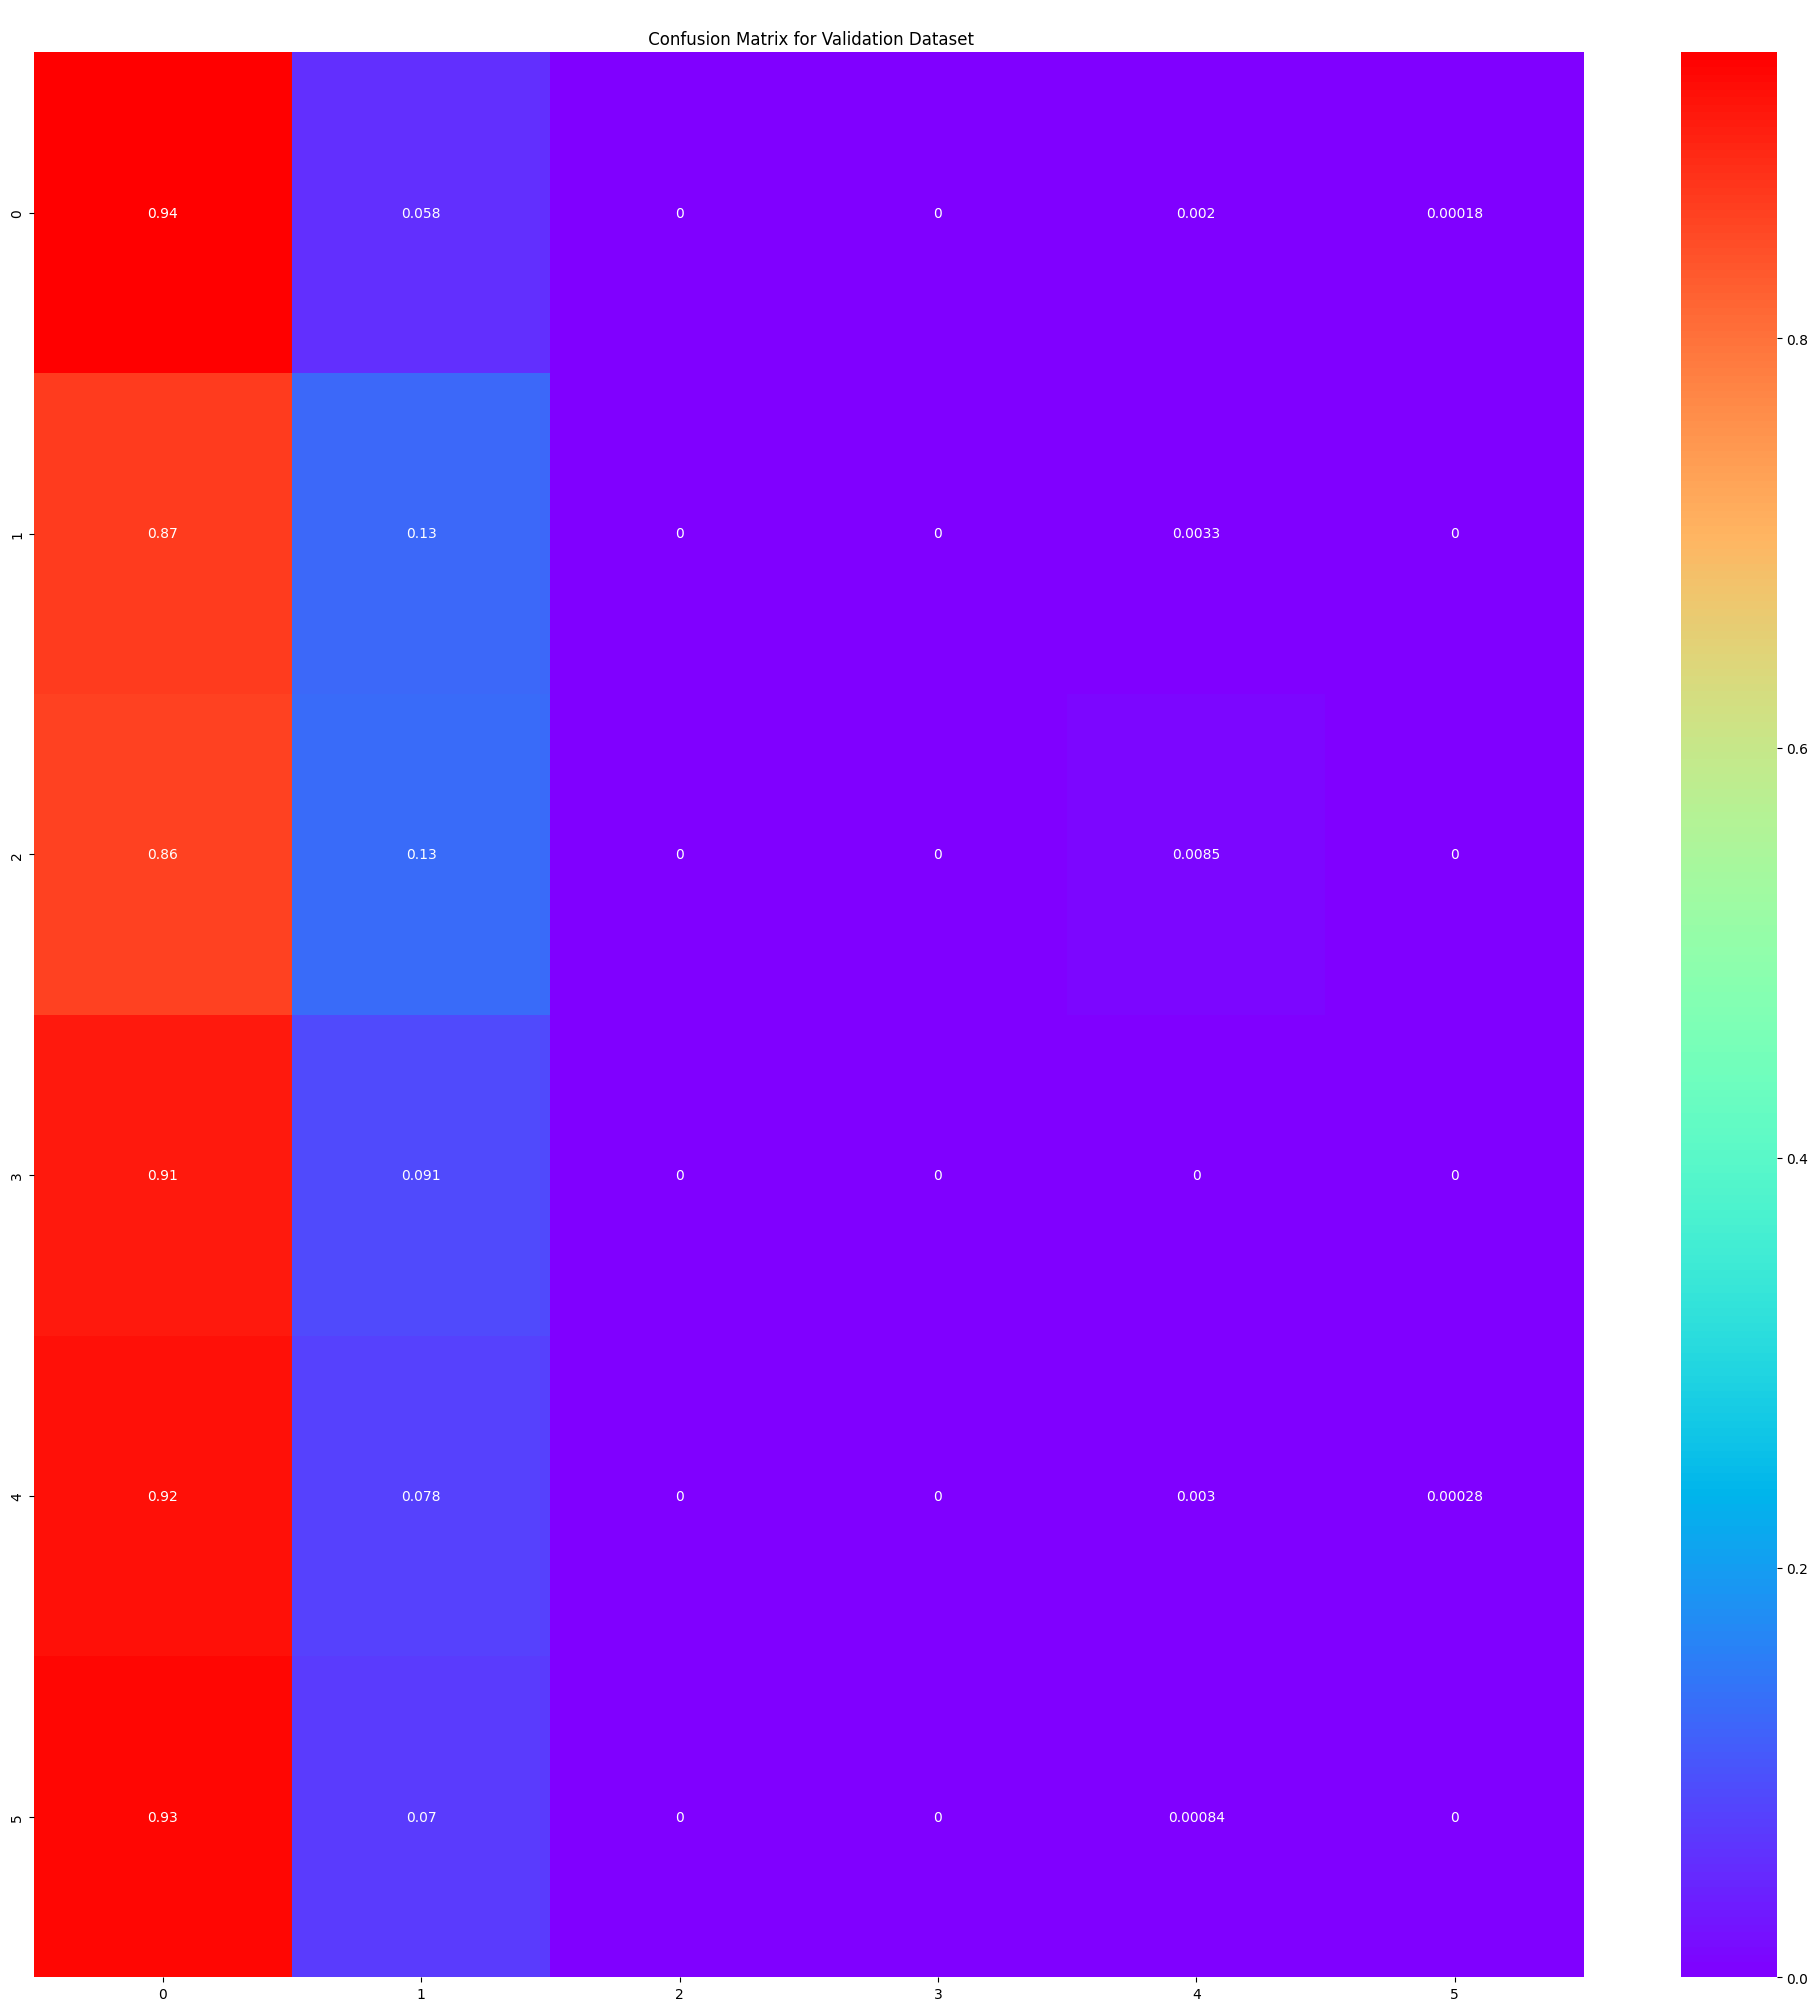

In [ ]:
model_analysis(model, train_dataloader)